In [1]:
from datetime import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import patsy

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from scipy.stats import ks_2samp

In [2]:
#  Abrindo o dataset
df = pd.read_excel(r"C:\Users\sabri\MBA Times - Final.xlsx")
df.head()

,replay_id,replay_title,date,result,team_name,opposing_team_name,score,goals,assists,saves,shots,demos_inflicted,demos_taken,shooting_percentage,save_conceded
0,4b679bcb-07b3-4e92-b9d5-dd93627b31e3,APAC Y GS vs K16 G3 2022-10-22.19.06,2022-10-22,loss,1620 KINGS,GOD SPEED,0,0,0,0,0,0,0,0.00,0.00
1,049ddd16-91ff-42b5-97f3-19fa67c3c55f,APAC A JMCH VS K16 G3 2022-10-23.17.19,2022-10-23,loss,1620 KINGS,JAMES CHEESE,488,0,0,1,2,3,4,0.00,0.14
2,761466d2-cb6d-4da2-a9aa-3861a4f0a858,APAC Q K16 vs JMCH G2 2022-10-08.18.15,2022-10-08,loss,1620 KINGS,JAMES CHEESE,833,0,0,8,2,3,4,0.00,0.47
3,ef7ced67-3865-4d13-8aad-cca35a8ba38d,APAC Q K16 vs JMCH G1 2022-10-08.18.03,2022-10-08,loss,1620 KINGS,JAMES CHEESE,988,2,1,5,2,3,3,100.00,0.28
4,8c15d7f6-4162-44cd-8dd0-42b9ce60d92d,APAC J K16 vs TL G2 2022-10-08.16.48,2022-10-08,loss,1620 KINGS,TOUGH LOVE,830,1,1,4,3,3,3,33.33,0.50


<AxesSubplot:>

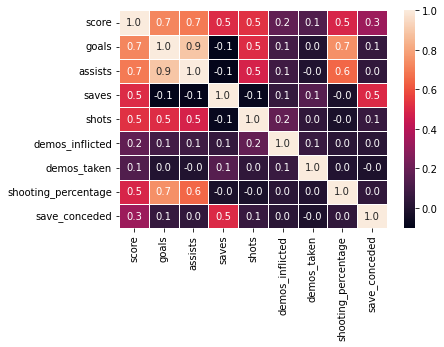

In [3]:
#  A variável score é calculada como função de: goals, assists, saves, shots, toques de bola.
#  Para gol = +100 score 
#  Para assist = +50 score ou +75 score
#  Para save = +50 score
#  Para shot = +10 score
#  Para toque de bola = +2 score
#  Não há registro nos dados de quando uma dada save é +50 ou +75, mas +50 é o padrão.
#  A correlação entre as features pode ser ilustrada pela matriz de correlação:
correlation = df.corr()
plot = sns.heatmap(correlation, annot = True, fmt = ".1f", linewidths=.6)
plot

In [4]:
#  Transformando result em variável binária. Loss = 1 e win = 0
df1 = pd.get_dummies(df['result'])
#df1.head()
df1 = df1.drop(['win'], axis = 1)
#df1.head()
df = pd.concat((df, df1), axis = 1)
#df.head()
df = df.drop(['result'], axis = 1)
df = df.rename(columns = {'loss': 'result'})
df.head()

,replay_id,replay_title,date,team_name,opposing_team_name,score,goals,assists,saves,shots,demos_inflicted,demos_taken,shooting_percentage,save_conceded,result
0,4b679bcb-07b3-4e92-b9d5-dd93627b31e3,APAC Y GS vs K16 G3 2022-10-22.19.06,2022-10-22,1620 KINGS,GOD SPEED,0,0,0,0,0,0,0,0.00,0.00,1
1,049ddd16-91ff-42b5-97f3-19fa67c3c55f,APAC A JMCH VS K16 G3 2022-10-23.17.19,2022-10-23,1620 KINGS,JAMES CHEESE,488,0,0,1,2,3,4,0.00,0.14,1
2,761466d2-cb6d-4da2-a9aa-3861a4f0a858,APAC Q K16 vs JMCH G2 2022-10-08.18.15,2022-10-08,1620 KINGS,JAMES CHEESE,833,0,0,8,2,3,4,0.00,0.47,1
3,ef7ced67-3865-4d13-8aad-cca35a8ba38d,APAC Q K16 vs JMCH G1 2022-10-08.18.03,2022-10-08,1620 KINGS,JAMES CHEESE,988,2,1,5,2,3,3,100.00,0.28,1
4,8c15d7f6-4162-44cd-8dd0-42b9ce60d92d,APAC J K16 vs TL G2 2022-10-08.16.48,2022-10-08,1620 KINGS,TOUGH LOVE,830,1,1,4,3,3,3,33.33,0.50,1


In [5]:
df = df.dropna(axis=0)
df.shape
df['result'].count()

19887

In [6]:
#  Abordagem 1 para score:

#  Score = 100goal + 50assist + 50save + 10shot + 2toque; 
#  Utilizando os dados conhecidos para estimar o número de toques de bola


df['ball_touches'] = (df['score'] - df['goals']*100 - df['assists']*50 - df['saves']*50 - df['shots']*10)/2  

In [7]:
#  Elimino agora a variável score e faço as previsões a partir desse novo dataset
df.drop('score', axis = 1, inplace = True)

In [8]:
#  Separando a base de teste
periodo_des = df[df['date'] < datetime(2023,6,1)].copy()
oot = df[df['date'] >= datetime(2023,6,1)].copy()


In [9]:
#  Separando features e targets da base de teste
x_oot = oot.drop(['result', 'replay_id', 'replay_title', 'date', 'team_name', 'opposing_team_name'], axis=1)
y_oot = oot['result']

In [10]:
#  Separando a base de desenvolvimento em treino e validação
from sklearn.model_selection import train_test_split

X = periodo_des.drop(['result', 'replay_id', 'replay_title', 'date', 'team_name', 'opposing_team_name'], axis=1)
y = periodo_des['result']
  
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((12902, 9), (4301, 9))

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# predict the mode
y_pred = model.predict(X_test)
classification_report(y_test, y_pred)
# performance evaluatio metrics
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2172
           1       0.90      0.91      0.90      2129

    accuracy                           0.90      4301
   macro avg       0.90      0.90      0.90      4301
weighted avg       0.90      0.90      0.90      4301



In [12]:
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_leaf_nodes': [9, 12, 15],
    'learning_rate': [.1, .25, .5, 1]
}

In [13]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [14]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(GradientBoostingClassifier(),
                           param_grid=param_grid,
                          cv = cv)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

GradientBoostingClassifier(learning_rate=0.25, max_leaf_nodes=9)


In [19]:
model = GradientBoostingClassifier(max_leaf_nodes = 9, learning_rate = .25)
model.fit(X_train, y_train)


# predict the mode
y_pred = model.predict(X_test)
av1 = classification_report(y_test, y_pred)
y_pred1 = model.predict(x_oot)
av2 = classification_report(y_oot, y_pred1)
# performance evaluatio metrics
print(av1, av2)


              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2148
           1       0.91      0.90      0.90      2153

    accuracy                           0.90      4301
   macro avg       0.90      0.90      0.90      4301
weighted avg       0.90      0.90      0.90      4301
               precision    recall  f1-score   support

           0       0.90      0.91      0.91      1342
           1       0.91      0.90      0.90      1342

    accuracy                           0.90      2684
   macro avg       0.91      0.90      0.90      2684
weighted avg       0.91      0.90      0.90      2684



In [20]:
#  Visualização
# Import tools needed for visualization
#from sklearn.tree import export_graphviz
#import pydot
# Pull out one tree from the forest
#tree = model.estimators_[5]
feature_list = list(X.columns)
# predict the mode
y_pred0 = model.predict(X_train)
av0 = classification_report(y_train, y_pred0)
print(av0)
# Export the image to a dot file
#export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('tree.png')

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      6454
           1       0.92      0.93      0.92      6448

    accuracy                           0.92     12902
   macro avg       0.92      0.92      0.92     12902
weighted avg       0.92      0.92      0.92     12902



In [21]:
#  Importância das variáveis
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance

#feature_importances = [(X, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Print out the feature and importances 
print(feature_list, importances)

['goals', 'assists', 'saves', 'shots', 'demos_inflicted', 'demos_taken', 'shooting_percentage', 'save_conceded', 'ball_touches'] [0.6191545845037395, 0.0015100202435149575, 0.0862985460387386, 0.003048645057952072, 0.001559975420817202, 0.003627291398262904, 0.03767010386526589, 0.23398505032329767, 0.013145783148411179]


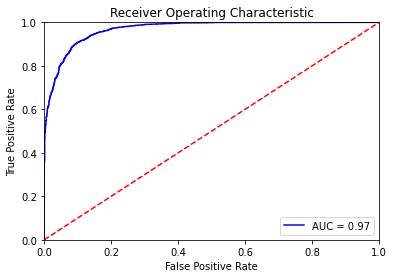

In [22]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
df['ball_touches'].describe()

count    19887.000000
mean       250.270378
std         63.504880
min          0.000000
25%        211.500000
50%        239.000000
75%        273.000000
max        872.500000
Name: ball_touches, dtype: float64